In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import seaborn as sns 

## Cleaning Data

In [ ]:

dir_path = 'data'
metals = ["Nickel", "Tin", "Copper", "Tungsten", "Chromium"]

df = pd.DataFrame()
for i, filename in enumerate(os.listdir(dir_path)):
    data = pd.read_excel(os.path.join(dir_path, filename), header=4)
    data.columns = [c.strip().replace("  ", " ") for c in data.columns]
    data["Metals"] = metals[i]
    df = pd.concat([df, data])
df = df.dropna(how="all", axis=1)

In [ ]:
df = df[df['Year'].apply(lambda x: str(x).isdigit())]
df['Year'] = df['Year'].astype(int)
df['Primary production'] = df['Primary production'].apply(lambda x: int(x) if str(x).replace('.', '').isdigit() else np.nan).astype(float)
df['Secondary production'] = df['Secondary production'].apply(lambda x: int(x) if str(x).replace('.', '').isdigit() else np.nan).astype(float)
df['Apparent consumption'] = df['Apparent consumption'].apply(lambda x: int(x) if str(x).isdigit() else np.nan).astype(float)
df = df.drop('Unit value ($/t)', axis = 1)

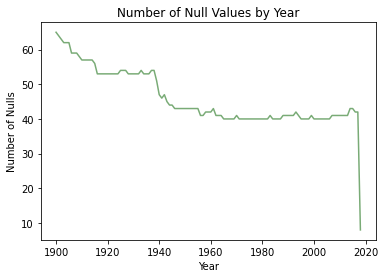

In [ ]:
df_year = df.drop('Year', 1).isna().groupby(df.Year, sort=False).sum().reset_index()
num_null = df_year[df_year.columns[1:]].sum(axis=1).values
plt.plot(df_year['Year'], num_null, color='#79ab76')
plt.title("Number of Null Values by Year")
plt.xlabel("Year")
plt.ylabel("Number of Nulls")
plt.savefig('null_year.png')

There are increasingly more null values as we look further into the past. We now plot the null values by columns to see which columns we can drop.

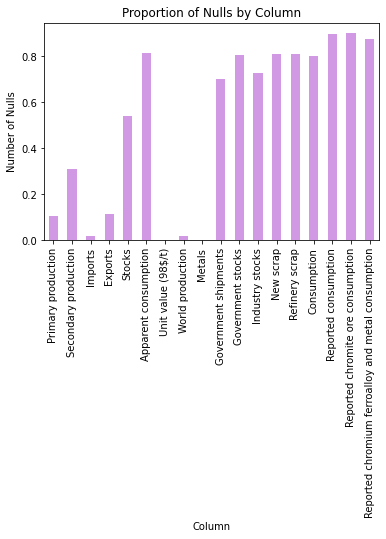

In [ ]:
df.drop('Year', 1).isna().mean().plot.bar(color='#d198e3')
plt.xlabel('Column')
plt.ylabel('Number of Nulls')
plt.title('Proportion of Nulls by Column')
plt.savefig('null_cat.png')

We'll drop columns that have majority null values (300+/591)

In [ ]:
nulls = df.isna().sum() 
df_sub = df[(nulls.loc[nulls < 300].index)]

In [ ]:
def metal_df(df, metal):
    df = df.loc[df["Metals"] == metal]
    df = df.drop(columns="Metals")
    return df

We can now do tailored analysis for each metal.

## Linearity

In [ ]:
from statsmodels.formula.api import ols

In [ ]:
df_sub.columns = ["Year", "PrimaryProduction", "SecondaryProduction", "Imports", "Exports", "Value", "WorldProduction", "Metals"]

In [ ]:
def resid_plot(df, ax, metal):
    model = ols('Value ~ Year + PrimaryProduction + SecondaryProduction + Imports + Exports + WorldProduction', data=df).fit()
    preds = model.predict()
    resids = model.resid

    sns.regplot(x=preds, y=resids, lowess=True, ax=ax, line_kws={'color': 'red'})
    ax.set(xlabel="Predictions", ylabel="Residuals")
    ax.set_title("Residuals v. Predictions ({})".format(metal))

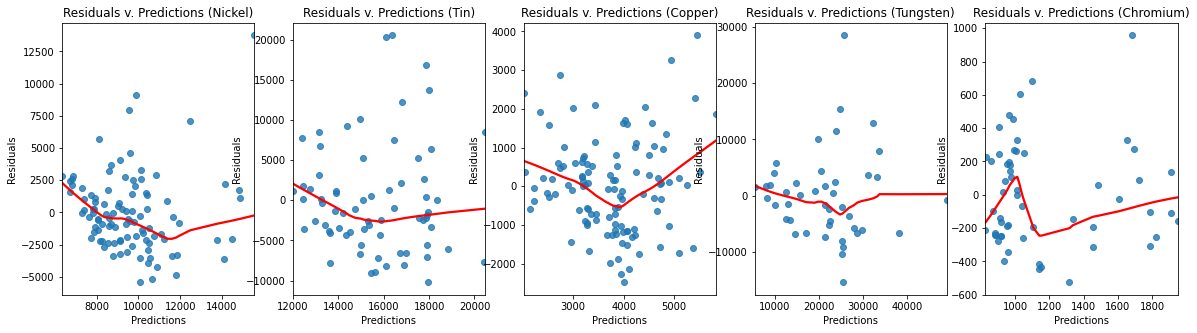

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(20, 5))
for i, metal in enumerate(metals):
    resid_plot(metal_df(df_sub, metal), ax[i], metal)
plt.savefig('resid_plot.png')

In [ ]:
def resid_hist(df, ax, metal):
    model = ols('Value ~ Year + PrimaryProduction + SecondaryProduction + Imports + Exports + WorldProduction', data=df).fit()
    preds = model.predict()
    resids = model.resid

    ax.hist(resids)
    ax.set(xlabel="Residuals", ylabel="Count")
    ax.set_title("Residuals Histogram ({})".format(metal))

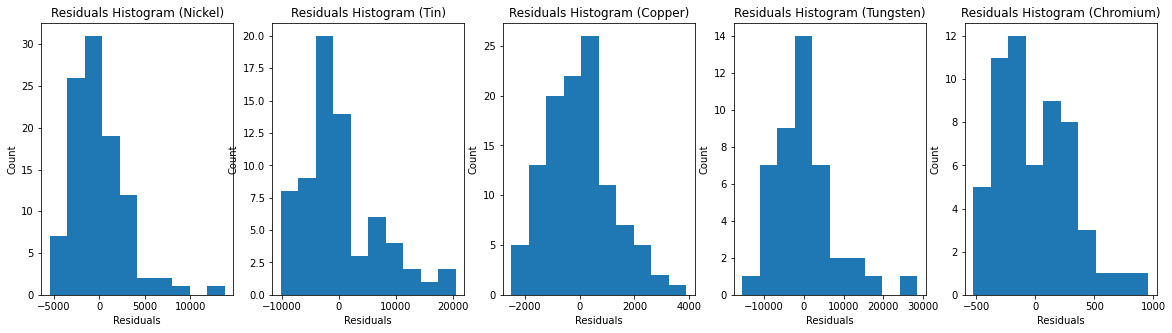

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(20, 5))
for i, metal in enumerate(metals):
    resid_hist(metal_df(df_sub, metal), ax[i], metal)
plt.savefig('resid_hist.png')

## FRED Data 

In [ ]:
xls = pd.ExcelFile('fred_data/Metal_Market_Data.xls')
fred_data = pd.read_excel(xls, 'Annual')
fred_data.columns = ['year', 'prod_equip', 'CPI', 'GDP', 'capital_stock', 'TFP']
fred_data.head(1)



,year,prod_equip,CPI,GDP,capital_stock,TFP
0,1929-01-01,0.216,NaN,104.556,NaN,NaN


In [ ]:
#from datetime to year
years = []
for obs in fred_data['year']:
    years.append(obs.year)

fred_data['year'] = years


#merge data
df = df_sub.merge(fred_data, left_on="Year", right_on="year", how="left")
df.head(1)

,Year,PrimaryProduction,SecondaryProduction,Imports,Exports,Value,WorldProduction,Metals,year,prod_equip,CPI,GDP,capital_stock,TFP
0,1900,5.0,NaN,26100.0,2660.0,22000.0,9290.0,Nickel,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Normalized Value')

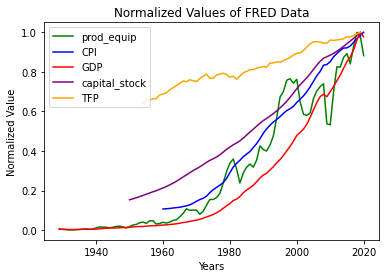

In [ ]:
year = fred_data['year']
plt.plot(year,fred_data['prod_equip']/39.231, color = 'green',label = 'prod_equip')
plt.plot(year,fred_data['CPI']/108.582120818832, color = 'blue', label = 'CPI')
plt.plot(year,fred_data['GDP']/21433.226, color = 'red', label = 'GDP')
plt.plot(year,fred_data['capital_stock']/69059072, color = 'purple', label = 'capital_stock')
plt.plot(year,fred_data['TFP']/1.0168620347976685, color = 'orange', label = 'TFP')
plt.legend()
plt.title('Normalized Values of FRED Data')
plt.xlabel('Years')
plt.ylabel('Normalized Value')

We see a general trend of all the FRED Data over the years

Text(0.5, 1.0, 'Number of Nulls by Column')

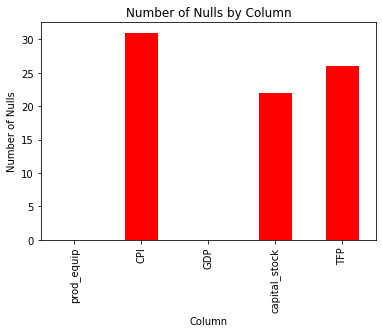

In [ ]:
fred_data.drop('year', 1).isna().sum().plot.bar(color='red')
plt.xlabel('Column')
plt.ylabel('Number of Nulls')
plt.title('Number of Nulls by Column')

## EDA


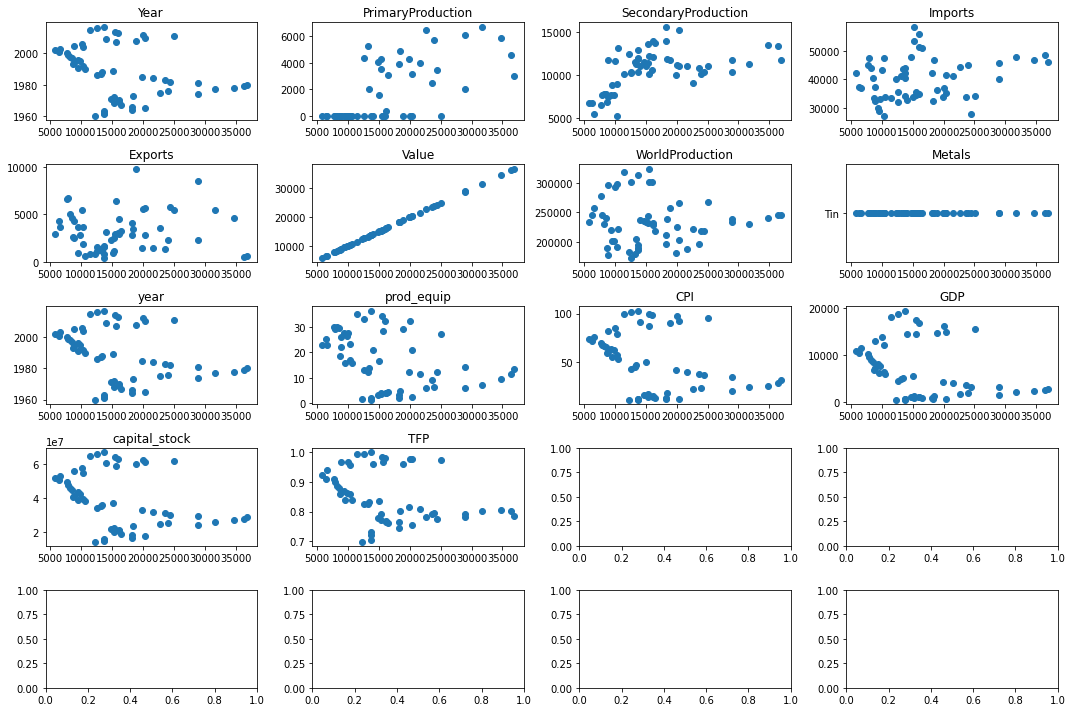

In [ ]:
tin_df = df.loc[df['Metals'] == 'Tin'].dropna(axis = 1, how = 'all')
tin_df = tin_df.loc[df['Year'] >= 1960]
#Tin scatters

fig, axes = plt.subplots(5,4, figsize = (15, 10))

axes = axes.flatten()
for i, col in enumerate(tin_df.columns):
    
    axes[i].scatter(x = tin_df['Value'], y = tin_df[col])
    axes[i].set_title(col)

fig.tight_layout()

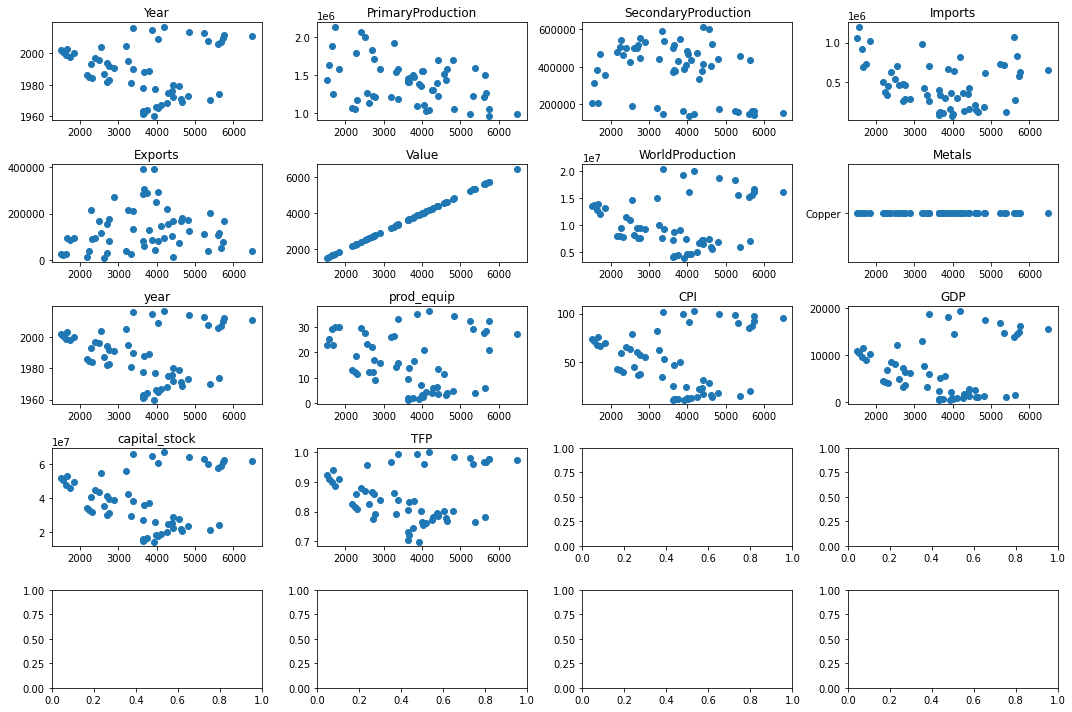

In [ ]:
copper_df = df.loc[df['Metals'] == 'Copper'].dropna(axis = 1, how = 'all')
copper_df = copper_df.loc[df['Year'] >= 1960]
#Copper scatters
fig, axes = plt.subplots(5,4, figsize = (15, 10))

axes = axes.flatten()
for i, col in enumerate(copper_df.columns):
    
    axes[i].scatter(x = copper_df['Value'], y = copper_df[col])
    axes[i].set_title(col)

fig.tight_layout()

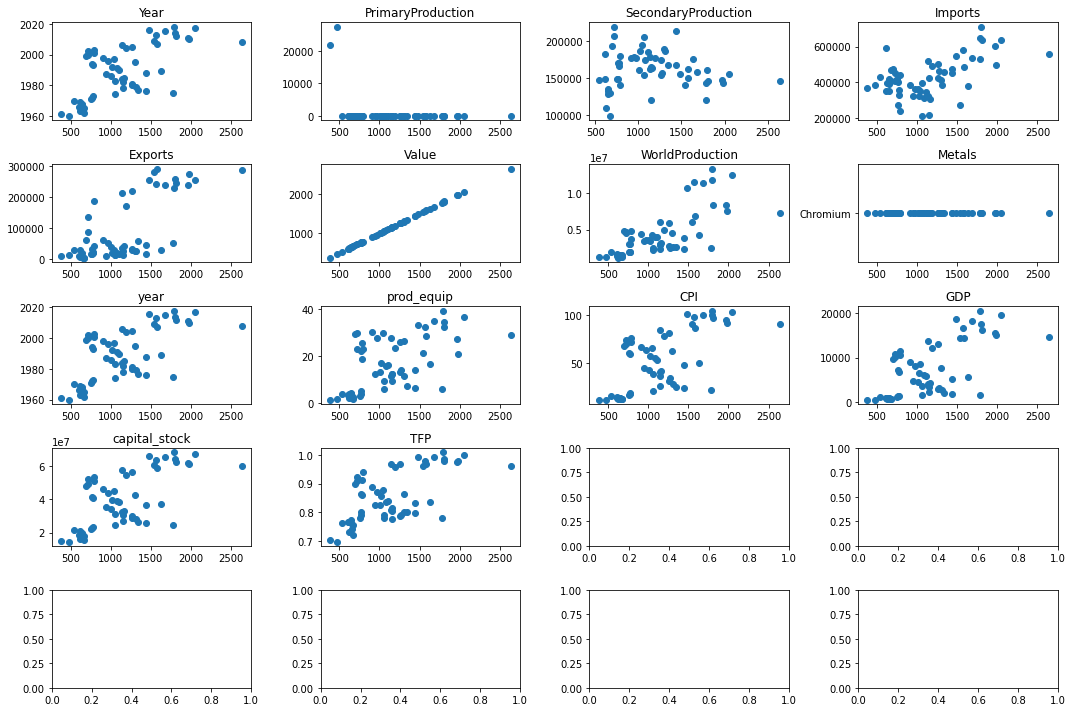

In [ ]:
chrom_df = df.loc[df['Metals'] == 'Chromium'].dropna(axis = 1, how = 'all')
chrom_df = chrom_df.loc[df['Year'] >= 1960]
#chromium scatters
fig, axes = plt.subplots(5,4, figsize = (15, 10))

axes = axes.flatten()
for i, col in enumerate(chrom_df.columns):
    
    axes[i].scatter(x = chrom_df['Value'], y = chrom_df[col])
    axes[i].set_title(col)

fig.tight_layout()

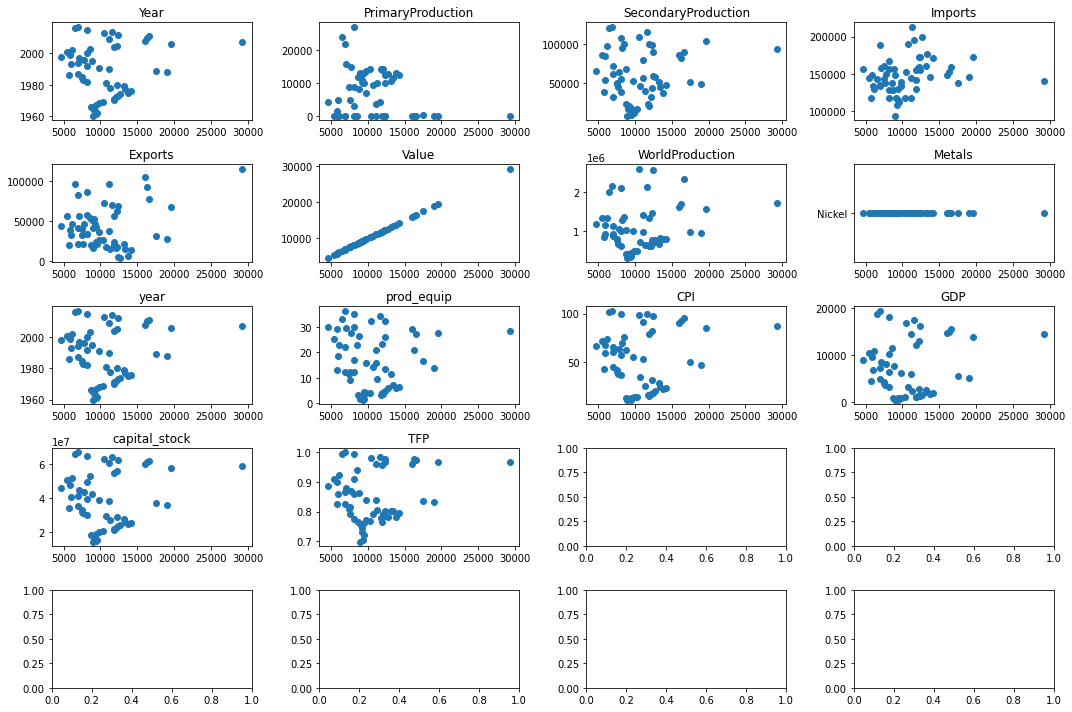

In [ ]:
nickel_df = df.loc[df['Metals'] == 'Nickel'].dropna(axis = 1, how = 'all')
nickel_df = nickel_df.loc[df['Year'] >= 1960]
#Nickel scatters
fig, axes = plt.subplots(5,4, figsize = (15, 10))

axes = axes.flatten()
for i, col in enumerate(nickel_df.columns):
    
    axes[i].scatter(x = nickel_df['Value'], y = nickel_df[col])
    axes[i].set_title(col)

fig.tight_layout()

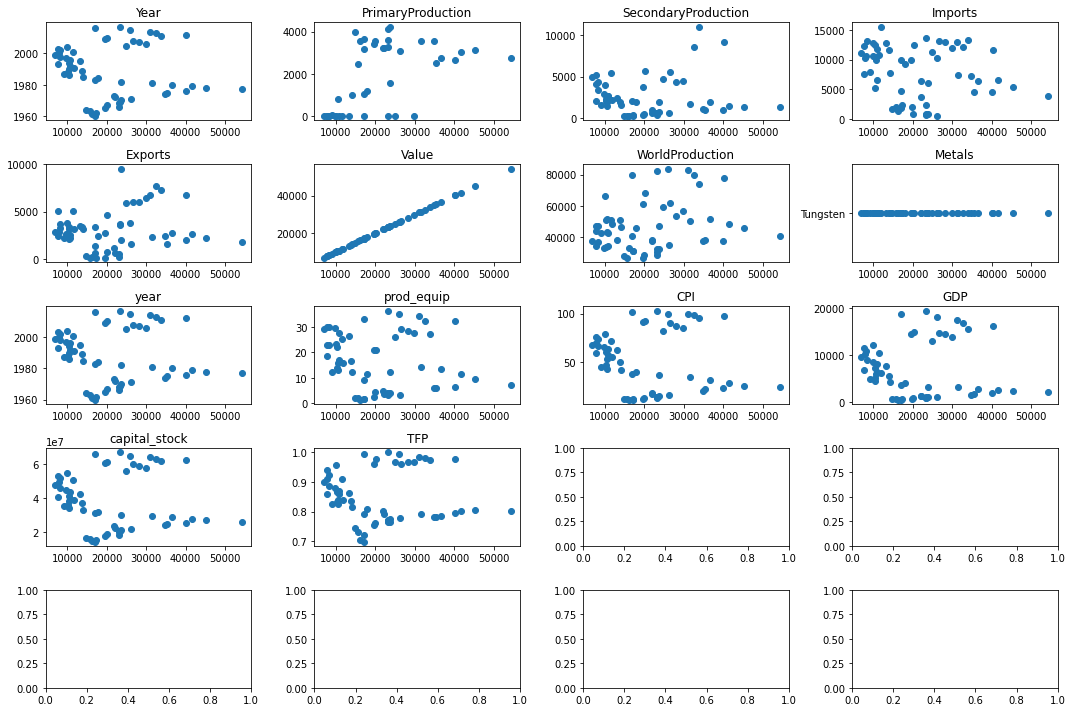

In [ ]:
tung_df = df.loc[df['Metals'] == 'Tungsten'].dropna(axis = 1, how = 'all')
tung_df = tung_df.loc[df['Year'] >= 1960]
#Tungsten scatters
fig, axes = plt.subplots(5,4, figsize = (15, 10))

axes = axes.flatten()
for i, col in enumerate(tung_df.columns):
    
    axes[i].scatter(x = tung_df['Value'], y = tung_df[col])
    axes[i].set_title(col)

fig.tight_layout()

## Lasso Regression

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

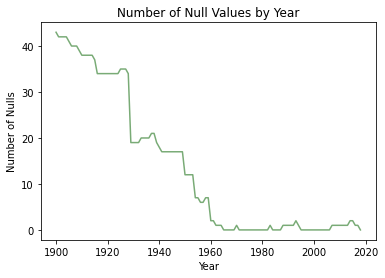

In [ ]:
df_year = df.drop('Year', 1).isna().groupby(df.Year, sort=False).sum().reset_index()
num_null = df_year[df_year.columns[1:]].sum(axis=1).values
plt.plot(df_year['Year'], num_null, color='#79ab76')
plt.title("Number of Null Values by Year")
plt.xlabel("Year")
plt.ylabel("Number of Nulls")
plt.savefig('null_year.png')

In [ ]:
df_test = df.loc[df["Year"] >= 1980].copy()
df_train = df.loc[df["Year"] < 1980].copy()

In [ ]:
alpha = [10**x for x in range(-5, 5)]
valid_scores = {}
for metal in metals:
    scores = {}
    met = metal_df(df_train, metal)
    met = met.loc[met["Year"] >= 1960].fillna(met.mean())
    X_train = met.drop("Value", axis=1)
    y_train = met["Value"]
    for a in alpha:
        lasso = Lasso(alpha=a, max_iter=3000, normalize = True, tol = np.e**(-1))
        pipeline = Pipeline([('scaler', StandardScaler()), ('lasso', lasso)])
        
        mse = cross_validate(pipeline, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')['test_score']
        scores[a] = np.mean([np.sqrt(m*-1) for m in mse.tolist()]) 
    valid_scores[metal] = scores

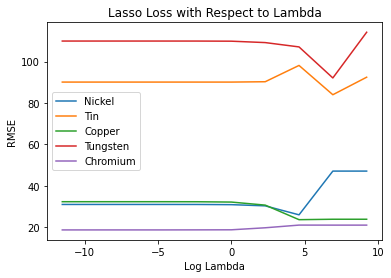

In [ ]:
cv_scores = pd.DataFrame(valid_scores)
lambdas = cv_scores.idxmin().to_dict()
for col in cv_scores.columns:
    x = [np.log(c) for c in list(cv_scores.index)]
    plt.plot(x, cv_scores[col].values, label=col)
    plt.legend()
plt.xlabel("Log Lambda")
plt.ylabel("RMSE")
plt.title("Lasso Loss with Respect to Lambda")
plt.savefig("lassoloss1980.png")

In [ ]:
lambdas

{'Nickel': 100.0,
 'Tin': 1000.0,
 'Copper': 100.0,
 'Tungsten': 1000.0,
 'Chromium': 1e-05}

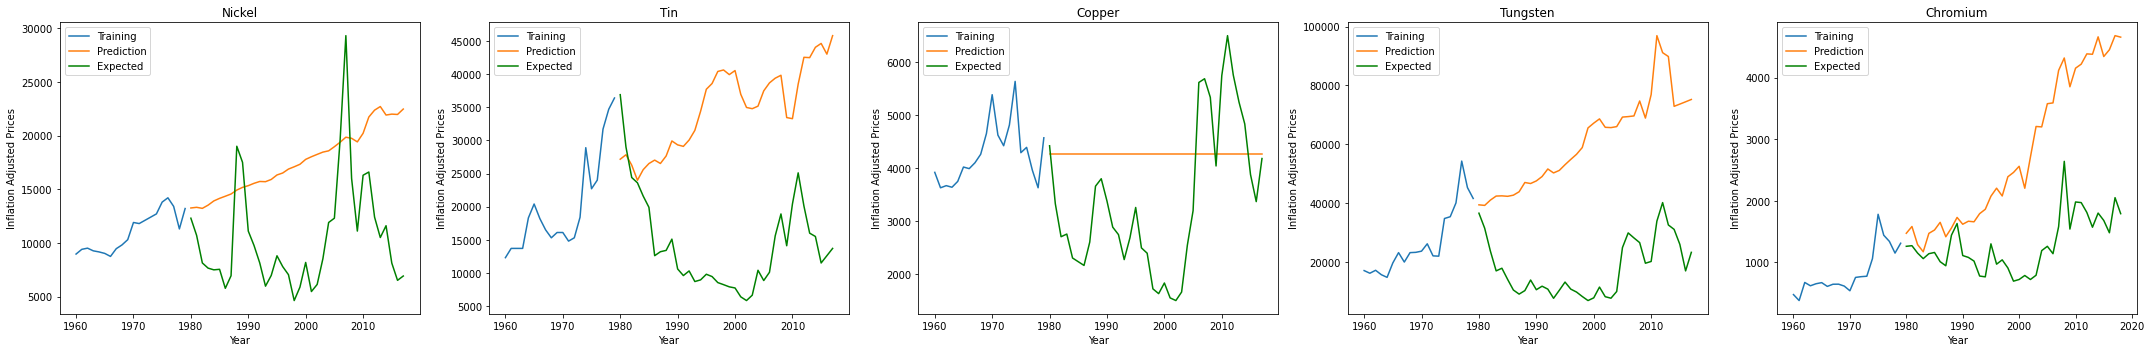

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(30, 5))
test_loss = {}
train_loss = {}
for i, metal in enumerate(metals):
    met = metal_df(df_train, metal)
    met = met.loc[met["Year"] >= 1960].fillna(met.mean())
    X_train = met.drop("Value", axis=1)
    y_train = met["Value"]

    met = metal_df(df_test, metal)
    met = met.fillna(met.mean()).fillna(0)
    X_test = met.drop("Value", axis=1)
    y_test = met["Value"]

    lasso = Lasso(alpha=lambdas[metal], max_iter=3000, normalize = True, tol = np.e**(-1))
    pipeline = Pipeline([('scaler', StandardScaler()), ('lasso', lasso)])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    test_loss[metal] = np.sqrt(np.mean((preds - y_test)**2))

    preds_train = pipeline.predict(X_train)
    train_loss[metal] = np.sqrt(np.mean((preds_train - y_train)**2))

    ax[i].plot(X_train["Year"], y_train, label = "Training")
    ax[i].plot(X_test["Year"], preds, label="Prediction")
    ax[i].set(xlabel="Year", ylabel="Inflation Adjusted Prices", title=metal)
    ax[i].plot(X_test["Year"], y_test, color = 'green', label="Expected")
    ax[i].legend()
fig.tight_layout()
plt.savefig("predictions1980.png")

In [ ]:
train_loss

{'Nickel': 787.8340938980314,
 'Tin': 5282.01924311107,
 'Copper': 547.8254740334736,
 'Tungsten': 6277.922155104978,
 'Chromium': 146.76312688967198}

In [ ]:
test_loss

## General LASSO Regression


In [ ]:
df_test = df.loc[df["Year"] >= 2015].copy()
df_train = df.loc[df["Year"] < 2015].copy()

alpha = [10**x for x in range(-5, 5)]
valid_scores = {}
for metal in metals:
    scores = {}
    met = metal_df(df_train, metal)
    met = met.loc[met["Year"] >= 1960].fillna(met.mean())
    X_train = met.drop("Value", axis=1)
    y_train = met["Value"]
    for a in alpha:
        lasso = Lasso(alpha=a, max_iter=3000, normalize = True, tol = np.e**(-1))
        pipeline = Pipeline([('scaler', StandardScaler()), ('lasso', lasso)])
        
        mse = cross_validate(pipeline, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')['test_score']
        scores[a] = np.mean([np.sqrt(m*-1) for m in mse.tolist()]) 
    valid_scores[metal] = scores



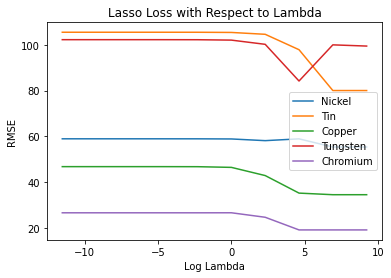

In [ ]:
cv_scores = pd.DataFrame(valid_scores)
lambdas = cv_scores.idxmin().to_dict()
for col in cv_scores.columns:
    x = [np.log(c) for c in list(cv_scores.index)]
    plt.plot(x, cv_scores[col].values, label=col)
    plt.legend()
plt.xlabel("Log Lambda")
plt.ylabel("RMSE")
plt.title("Lasso Loss with Respect to Lambda")
plt.savefig("lassoloss2015.png")

In [ ]:
lambdas

{'Nickel': 1000.0,
 'Tin': 1000.0,
 'Copper': 1000.0,
 'Tungsten': 100.0,
 'Chromium': 100.0}

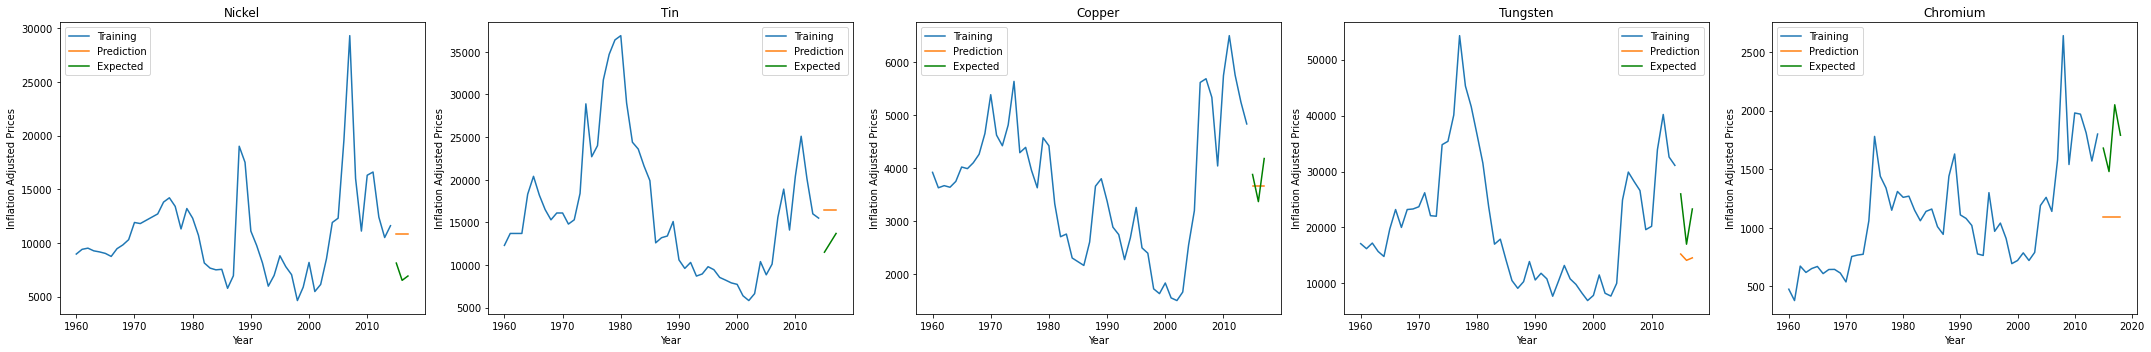

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(30, 5))
test_loss = {}
train_loss = {}
for i, metal in enumerate(metals):
    met = metal_df(df_train, metal)
    met = met.loc[met["Year"] >= 1960].fillna(met.mean())
    X_train = met.drop("Value", axis=1)
    y_train = met["Value"]

    met = metal_df(df_test, metal)
    met = met.fillna(met.mean()).fillna(0)
    X_test = met.drop("Value", axis=1)
    y_test = met["Value"]

    lasso = Lasso(alpha=lambdas[metal], max_iter=3000, normalize = True, tol = np.e**(-1))
    pipeline = Pipeline([('scaler', StandardScaler()), ('lasso', lasso)])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    test_loss[metal] = np.sqrt(np.mean((preds - y_test)**2))

    preds_train = pipeline.predict(X_train)
    train_loss[metal] = np.sqrt(np.mean((preds_train - y_train)**2))

    ax[i].plot(X_train["Year"], y_train, label = "Training")
    ax[i].plot(X_test["Year"], preds, label="Prediction")
    ax[i].set(xlabel="Year", ylabel="Inflation Adjusted Prices", title=metal)
    ax[i].plot(X_test["Year"], y_test, color = 'green', label="Expected")
    ax[i].legend()
fig.tight_layout()
plt.savefig("predictions2015.png")

In [ ]:
train_loss

{'Nickel': 4209.435155763598,
 'Tin': 7652.526194468386,
 'Copper': 1259.9383429752322,
 'Tungsten': 8366.378418914042,
 'Chromium': 446.6405377004592}

In [ ]:
test_loss

{'Nickel': 3706.234878208853,
 'Tin': 3950.8952334889245,
 'Copper': 362.14124453275895,
 'Tungsten': 8175.712312572806,
 'Chromium': 688.371750180294}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9e2e2a9c-75c4-4b90-a8ab-4f70dc6a617d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>